# MODEL PROJECT

## 1. Introduction

We start in *section.3* with a classical intertemporal optimization problem in two periods. Our representative household exhibits a CRRA utility function and we want to detect the optimal bundle given underlying variables. In *section.4*, instead, we focus on the optimizing behaviour of our representative firm. Its production function satisfies the Inada condition and  exhibits positive but diminishing marginal products. We come up with the optimal conditions to satisfy profit maximization.   
In *section.5*, we add complexity to the model making our representative consumer and firm interact under the features of the classical Ramsey model. Here, we rely on the book *Robert J.Barro and Xavier Sala-i-Martin, Economic Growth* for the main results. We come up with the phase diagram for different consumption and capital paths trying to detect the unique saddle path and steady state for the particular variables we give to the problem. 

## 2. Import packages

In [2]:
import numpy as np
import scipy as sp
import math
from scipy import optimize
import sympy as sm
from scipy import linalg
from sympy import Derivative
from scipy import interpolate
import scipy.integrate as quad
from scipy.integrate import odeint
import scipy.special as special
from scipy.integrate import quad
from sympy import symbol,function
import ipywidgets as widgets
from IPython.display import display

#autoreload model when code is run
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

## 3. Consumer optimization problem

Before moving to the Ramsey model, we focus on our representative consumer and his optimization problem. The standard Ramsey model assumes that the household exhibits a CRRA utility function with respect to consumption of the type:  

$$u(c)=\frac{c^{1-\theta}-1}{1-\theta}$$  

where $\theta$ is a measure or relative risk aversion.
This type of preferences is really useful when $\theta=1$ because in this case the CRRA utility becomes a logarithmic utility. 
We create a simple utility maximization problem with two periods to detect how these preferences impact the consumer optimal behavior. We take into consideration two periods, $t=0$ and $t=1$.   
Our representative consumer maximizes consumption in the present $c_0$ and in the future $c_1$ taking into consideration his labour income will be $w_0$ today and $w_1$ tomorrow. So, our utility maximization problem become:  

$$max \hspace{2pt} U(c_0,c_1) = u(c_0)+e^{-\rho}u(c_1)$$  

under the constraint:  

$$c_0+\frac{1}{1+r}{c_1} = w_0 +\frac{1}{1+r}{w_1}$$  

where $\rho$ is the subjective discount rate and $r$ the interest rate.

Now, before solving the problem, we assume some initial values:

In [3]:
#a. Defining initial parameters
theta = 0.5
w_t= 10      #present labour income
w_t1 = 10     #future labour income
rho = 0.9
r = 0.5

#a. Defining utility function
def utility(ct):
    return (ct**(1-theta)-1)/(1-theta)

#b. Defining utility function for two periods
def inter_util(c_t, c_t1):
    return utility(c_t)+np.exp(-rho)*utility(c_t1)

#c. Defining constraint
def constraint(c_t,c_t1):
    return w_t+(1/(1+r))*w_t1-c_t-(1/(1+r))*c_t1


To solve the maximization problem we firstly set the lagrangian:  

$$L=\max_{c_{0},c_{2}}\bigg(\frac{c_{0}^{1 - \theta} - 1}{1 - \theta}\bigg) + e^{-\rho}\bigg(\frac{c_{1}^{1 - \theta} - 1}{1 - \theta}\bigg) + \lambda\bigg(w_{0} + \frac{1}{1 + r}w_{1} - c_{0} - \frac{1}{1 + r}c_{1}\bigg)$$  

and we compute the first order conditions:  

$$c_{0}^{-\theta} = \lambda$$
$$e^{-\rho}c_{1}^{-\theta}=\frac{1}{1 + r}\lambda$$  

The above reduces to:  

$$c_{0}^{-\theta} = e^{-\rho}(1 + r)c_{1}^{-\theta}$$    

We transpose the above into code:

In [4]:
#d. Defining Euler equation
def euler(c_t,c_t1):
    return c_t**(-theta)-np.exp(-rho)*(1+r)*(c_t1)**(-theta)

#e. Creating optimization function
def optimalchoice(x):
    op = [euler(x[0], x[1])]
    op.append(constraint(x[0],x[1]))
    return op
        
#f. Applying fsolve function
ct_guess, ct1_guess = 0.5, 0.5
ct_star, ct1_star = optimize.fsolve(optimalchoice, x0=(ct_guess, ct1_guess))
utility_star = inter_util(ct_star, ct1_star)
 
#g. Printing results
print(f'The optimal consumption at the present is: {ct_star:.2f}')
print(f'The optimal consumption tomorrow is: {ct1_star:.2f}')
print(f'Utility from optimal bundle is: {utility_star:.2f}')

The optimal consumption at the present is: 13.36
The optimal consumption tomorrow is: 4.97
Utility from optimal bundle is: 6.31


## 4. Firm optimization problem 

In the Ramsey model the representative firm has a production function that satisfies the neoclassical properties of constant return to scale in $K$ (capital) and $L$ (Labour) and each input exhibits positive but diminishing marginal product. 
The firm wants to maximize its profit:

$$\pi = F(K,L) - wL - (r+\delta)K$$

where $F(K,L)$ is the production function, $w$ is the wage rate, $r$ is the interest rate and $0 \leq \delta \leq 1$ the discount rate.  
In the Ramsey model, to obtain constant growth in the steady-state, we have to deal with quantities per unit of effective labor and so we will do assuming that the technology will be $T=1$. The production function will be rewritten in intensive form:  

$$\hat{y}=f(\hat{k})$$  

where $\hat{y}=\frac{Y}{LT}$ and $\hat{k}=\frac{K}{LT}$. The Profit function becomes:

$$\pi= f(\hat{k}) - w - (r+\delta)\hat{k}$$  

Specifically, we are going to assume the following production function:  

$$\hat{y}=f(\hat{k})=\hat{k}^{\alpha}$$  

where $0 \leq \alpha \leq 1$ is the capital share of output and $\hat{k}$ is capital per effective labour. 
From now on, for simplicity, we assume that technology will increase at the rate $x=0$.
We are going to check that the marginal product of capital is diminishing ($f''(\hat{k})< 0$), that the Inada conditions are satisfied and only afterwards we will calculate the profit maximization conditions.

In [7]:
#a. Creating parameters
sm.init_printing(use_unicode=True) # for pretty printing        
alpha = sm.symbols('alpha')        # capital share
k = sm.symbols('k')                # capital per effective worker               
w = sm.symbols('w')                # wage
K = sm.symbols('K')                # capital
L = sm.symbols('L')                # labour
T = sm.symbols('T')                # technology
delta = sm.symbols('delta')        # capital depreciation rate
r = sm.symbols('r')                # interest rate

The production function is:


The profit function is:


The first derivative with respect to k is:


The second derivative with respect to k is:


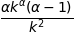

First Inada condition is:


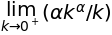

Second Inada condition is:


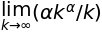

In [10]:
#b. Defining production function
prod = k**alpha
print(f'The production function is:')
display(prod)

#c. Defining profit function
profit = prod - (r+delta)*k - w
print(f'The profit function is:')
display(profit)

#d. Calculating first and second derivatives with respect to k
print(f'The first derivative with respect to k is:')
sol = sm.diff(prod,k)
display(sol)
print(f'The second derivative with respect to k is:')
sol1 = sm.diff(prod,k, k)
display(sol1)

#e. Check Inada conditions
print(f'First Inada condition is:')
inada1 = sm.Limit(sol,k,0)
display(inada1)
print(f'Second Inada condition is:')
inada2 = sm.Limit(sol,k, sm.oo)
display(inada2)


Clearly, the first derivative is positive and the second derivative is negative confirming decreasing marginal product of capital per effective labour. Even if it is already clear that the Inada conditions are satisfied, we are going to plot the production function for different values of alpha to check that it is concave.

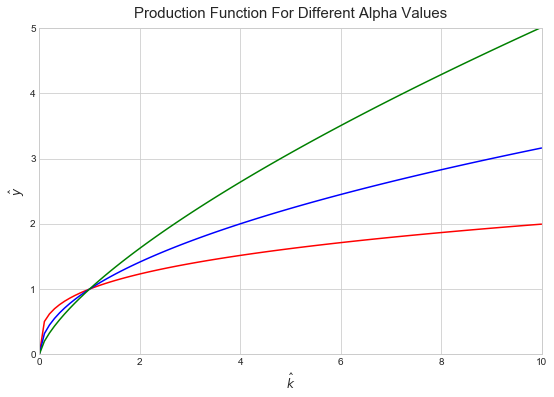

In [44]:
#f. Setting different parameters vaues
kvec = np.linspace(0,10,100)
alpha = 0.3
alpha1 = 0.5
alpha2 = 0.7
y = kvec**alpha
y1 = kvec**alpha1
y2 = kvec**alpha2

#g. Plotting the functions
prod_im = plt.figure(figsize = (9,6))
ax = prod_im.add_subplot(1, 1, 1)
ax.plot(kvec,y, 'red')
ax.plot(kvec,y1, 'blue')
ax.plot(kvec,y2, 'green')
ax.set_title('Production Function For Different Alpha Values', fontsize=15, pad=10)
ax.set_ylabel('$\hat{y}$', fontsize=12)
ax.set_xlabel('$\hat{k}$', fontsize=12)
ax.set_xlim(0,10)
ax.set_ylim(0,5)

plt.show()

So our production function is confirmed to be concave. Moreover, we can notice that higher levels of alpha lead to higher outcome per capita. We now move to the profit maximizing conditions.

In [25]:
#h. Profit maximization with respect to capital per effective worker
print(f'Optimazing the profit with respect to k, we obtain:')
profitk = sm.Eq(sm.diff(profit,k))
display(profitk)
print(f'And the optimal k is:')
profitk1 = sm.solve(profitk,k)
display(profitk1)



Optimazing the profit with respect to k, we obtain:


And the optimal k is:


## 5. Ramsey Model

We make now our representative consumer and firm interacting with each other under the classical framework of the Ramsey model. Our optimizing household of *section.2* mantains the same CRRA utility function with respect to consumption. The new element is that he maximizes over an infinite horizon taking into account the welfare and resources of his prospective descendants. He expects the size of his future family to grow at the rate $n$, given as exogenous and constant. We normalize the size of the family at time $t= \small{0}$ to 1, so that at the generic time $t$, the size of the family will be $L(t)=e^{nt}$. The utility maximization problem become:
 
$$U= \int_{0}^{\infty} e^{-(\rho-n)t}\left[\frac{c^{1-\theta}-1}{1-\theta}\right]dt$$

The household holds assets ($a(t)$) which pay rate of return $r(t)$ and supplies inelastically one unit of labor services for the wage rate $w(t)$. We assume a closed economy so that no assets can be traded internationally and we assume a competitive market so that the interest rate, r $r(t)$, and the wage rate $w(t)$ are given.                              
The total income received by the aggregate is the sum of labor income, $w(t)·L(t)$, and asset income, $r (t)·(Assets)$ and the income that it is not consumed, it is used to accumulate more assets:  

$$\frac{d(Assets)}{dt} = r(Assets)+wL-C$$  

In per-capita terms, the household budget constraint becomes:  

$$\dot{\alpha} = (r-n)\alpha+w-c$$

We assume that the credit market imposes a constraint on the amount of borrowing to rule out chain-letter possibilities. The appropriate restriction turns out to be that the present value
of assets must be asymptotically non-negative:  

$$\lim_{t \to \infty} \bigg\{ \alpha(t)*exp\left[-\int_{0}^{t}[r(v)-n]dv \right] \bigg\} = 0$$

Our representative firm maintains the same characteristics depicted in *Section.4*. As before, initial technology is normalized to 1  and for simplicity we assume that it grows at rate $x=0$.   
One unit of output can be used to generate one unit of household consumption or one unit of additional capital. Therefore, as long as the economy is not at a corner solution in which all current output goes into consumption or new capital, the price of k in terms of c will be fixed at unity. Because consumption will be nonzero in equilibrium, we have to be concerned only with the possibility that none of the output goes into new capital.

We briefly derive the fundamental equations of the model (for more analytical derivations have a look in *Barro & Martin, Chapter 2* and relative appendix).  
Since the economy is closed, the assets per adult person, $a$, equal the capital per worker, $k$. Given the consumer budget constraint, the optimizing conditions for $r$ and $w$ found in the *Section.4* and $a=k$, we get the resource constraint for the economy which determines the evolution for capital per effective labour:

$$\dot{\hat{k}} = \hat{k}^{\alpha} - \hat{c} -(x+n+\delta)\hat{k} \hspace{7pt}(1)$$

The differential equation that determines the evolution of the consumption per effective labour is instead:

$$\frac{\hat{c}}{c}-x=\frac{1}{\theta} \big[\alpha \hat{k}^{\alpha-1} -\delta -\rho-\theta x \big] \hspace{7pt}(2)$$

The transversality condition becomes:  

$$\lim_{t \to \infty} \bigg\{ \hat{k}*exp\left[-\int_{0}^{t}[\alpha \hat{k}^{\alpha-1} -\delta - n - x]dv \right] \bigg\} = 0$$

The steady state values for c and k are determined by setting the expression (1) and (2) to zero. The $\dot{k}=0$, locus is determined by:

$$\hat{c}= \hat{k}^{\alpha}-(x+n+\delta)\hat{k}$$

Equation (2) implies that the $\dot{c}=0$ locus is satisfied when:

$$\alpha \hat{k}^{\alpha-1}=\delta +\rho+\theta x$$

The determination of the steady state occurs at the intersection of the vertical line for $\dot{c}=0$ and the solid curve for $\dot{k}=0$ and the two equations for the steady state quantities are:

$$ \hat{k}^{*}=\big(\frac{\delta+\rho+ x\theta}{\alpha}\big)^{\frac{1}{\alpha-1}}$$

$$ \hat{c}^{*}=(k^{*})^{\alpha}-(n+\delta+x)k^{*}$$

The steady-state value for the production per effective labour becomes $\hat{y}^{*}=(\hat{k}^{*})^{\alpha}$ and the transversality condition implies that $\rho>n+(1-\theta)x$. If $\rho$ not satisfies this condition, the household's optimization problem is not well posed and infinite utility can be attained if consumption grew at the rate $x$.

We now start to code the main equation for the model and we find the steady-state values for consumption, capital and production for our given values of $\theta$, $\rho$, $n$, $\delta$, $\alpha$ and $x$.


In [7]:
#a. Parameter values 

theta = 3.0          # measure of relative risk aversion
rho = 0.03           # subjective discount rate
n = 0.02           # family growth rate
delta = 0.33          # depreciation rate of capital          
alpha = 0.35         # capital share rate
x= 0                  # technology growth rate

#b. Transversality condition must be satisfied
print(f'Is the transversality condition satisfied?')
def transversality():
    if  rho > n + (1 - theta)*x:
        print(f'Yes, it is satisfied.')
    else:
        print(f'No, it is not satisfied.')

transversality()

Is the transversality condition satisfied?
Yes, it is satisfied.


In [8]:
#c. Defining production function
def prod(k_t):
    return k_t**alpha

#d. Defining the consumption euler equation obtain from 1
def cons_t1(c_t, k_t):
    return np.exp(-x) * (np.exp(-rho) * (np.exp(-delta) + alpha * cap_t1(c_t, k_t)**(alpha - 1)))**(1 / theta) * c_t

#e. Defining the capital equation obtain from 2
def cap_t1(c_t,k_t):
    return np.exp(-(n + x)) * (prod(k_t) + np.exp(-delta) * k_t - c_t)


In [9]:
#f. Steady state capital
def k_star():
    return ((delta+rho)/alpha)**(1 / (alpha - 1))

#g. Steady state consumption
def c_star():
    return prod(k_star())-(delta+n)*k_star()

#h. Steady state production
def y_star():
    return (k_star())**alpha

#i. Values of steady state capital and consumption for our chosen variables
print(f'The steady state capital per effective labour is: {k_star():.2f}')
print(f'The steady state consumption per effective labour is: {c_star():.2f}')
print(f'The steady state production per effective labour is: {y_star():.2f}')

The steady state capital per effective labour is: 0.96
The steady state consumption per effective labour is: 0.65
The steady state production per effective labour is: 0.98


### 5.2 Generical Phase Diagram

The Ramsey model is interesting for its predictions about the path of capital and consumption growth given an initial condition $k(0)$. We now want to plot the generic phase diagram showing the nature of this dynamics 

In [10]:
#a. locus for capital
def locus_cap(k_t):
    return prod(k_t) - k_t*(delta + n)

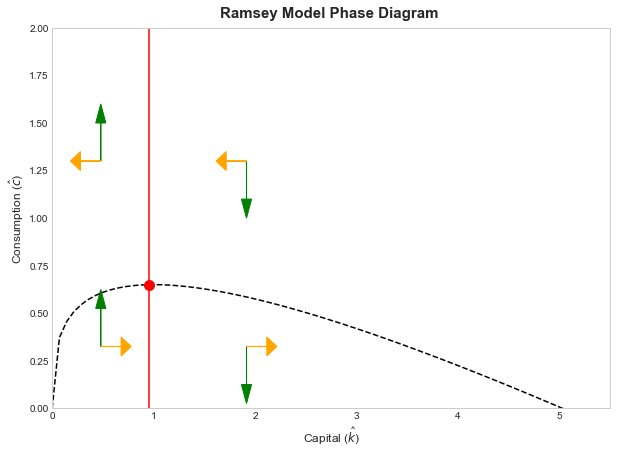

In [11]:
#b. Create a grid of points for plotting
x_vec = np.linspace(0, 500, 7000)

#c. Constructing the generic phase diagram 
phase = plt.figure(figsize=(10,7))
plt.xlim(0,5.5)
plt.ylim(0,2)
plt.grid(False)
plt.xlabel([])

#c.1 Adding the capital and consumption locii
plt.plot(x_vec, locus_cap(x_vec), linestyle ='--', color='black') 
plt.axvline(k_star(), linestyle = '-', color = 'red')
plt.plot(k_star(), c_star(), marker='o', markersize = 10, color ='red')

#c.2 Adding arrows to indicate dynamics 
plt.arrow((1/2)*k_star(), (1/2)*c_star(), dx=0, dy=0.2, head_width = 0.1, head_length= 0.1, color = 'green')
plt.arrow((1/2)*k_star(), (1/2)*c_star(), dx=0.2, dy=0, head_width = 0.1, head_length= 0.1, color = 'orange')
plt.arrow((1/2)*k_star(), 2*c_star(), dx=0, dy=0.2, head_width = 0.1, head_length= 0.1, color = 'green')
plt.arrow((1/2)*k_star(), 2*c_star(), dx=-0.2, dy=0, head_width = 0.1, head_length= 0.1, color = 'orange')

plt.arrow(2*k_star(), (1/2)*c_star(), dx=0, dy=-0.2, head_width = 0.1, head_length = 0.1, color = 'green')
plt.arrow(2*k_star(), (1/2)*c_star(), dx=0.2, dy=0, head_width = 0.1, head_length = 0.1, color = 'orange')
plt.arrow(2*k_star(), 2*c_star(), dx=0, dy=-0.2, head_width = 0.1, head_length = 0.1, color = 'green')
plt.arrow(2*k_star(), 2*c_star(), dx=-0.2, dy=0, head_width = 0.1, head_length = 0.1, color = 'orange')

#c.3 Adding axis labels and title
plt.xlabel('Capital ($\hat{k}$)', fontsize = 12)
plt.ylabel('Consumption ($\hat{c}$)', fontsize = 12)
plt.title('Ramsey Model Phase Diagram ', fontsize=15, weight='bold', pad = 10)
plt.show()

The dashed black line represents the $\dot{k}=0$ loci and red line the $\dot{c}=0$ loci (the other loci where $\dot{c}=0$ corresponds the the horizontal axis $\hat{c}=0$). The red dot displays, instead, the steady state.
The arrows depict the nature of the dinamics for consumption and capital. So, consumption rises for value of capital $\hat{k}<k^{*}$ (green arrows point upwards) and decreases otherwise (green arrown point downwards). Capital, instead, falls for values of consumption above the dashed loci (yellow arrows point leftwards) and rises for values below (yellow arrows point rightwards).

### 5.3 Plotting different  paths

In the previous subsection we got an overall idea of the dinamics of the systems. Now, we are going to plot the consumption/capital paths for different initial values of consumption. We will see that only one precise value of $c(0)$ will lead us to the the steady state and this path is called the saddle path.

In [12]:
#a. Create a class to make 
class Ramsey(object):
    
    def __init__(self, parameters, k_t=None, c_t=None):

        # current value of state variable, k
        self.k_t           = k_t
        # current value of the control variable, c
        self.c_t            = c_t
        # dictionary of parameter values
        self.par   = parameters
        # dictionary of steady state values        
        self.dict      = {'k_star':self.k_star_(self.par), 
                             'c_star':self.c_star_(self.par)}
        
        
    # steady state capital per effective labour
    def k_star_(self, parameters): 

        n     = parameters['n']
        x     = parameters['x']
        alpha = parameters['alpha']
        delta = parameters['delta']
        rho   = parameters['rho']
        theta = parameters['theta']
    
        return ((alpha * np.exp(-rho)) / (np.exp(theta * x) - np.exp(-(rho + delta))))**(1 / (1 - alpha))
    
    # steady state consumption per effective labour
    def c_star_(self, parameters): 
        
        # extract params
        x     = parameters['x']
        k_star = self.k_star_(parameters)
        
        return k_star**alpha + (np.exp(-delta) - np.exp(n + x)) * k_star
    
    # next period capital per effective labour
    def cap_t1(self, k_t, c_t): 
        
        return np.exp(-(n + x)) * (k_t**alpha + np.exp(-delta) * k_t - c_t)
    
    # next period consumption per effective labour
    def cons_t_1(self, k_t, c_t): 
    
        return np.exp(-x) * (np.exp(-rho) * (np.exp(-delta) + alpha * cap_t1(k_t, c_t)**(alpha - 1)))**(1 / theta) * c_t

    # generating futute kt+1 and ct+1 according to cons_t_1 and capital equations
    def upgrade(self):
       
        self.k_t = self.cap_t1(self.k_t, self.c_t) 
        self.c_t = self.cons_t_1(self.k_t, self.c_t)

    # geneating path of lenght n
    def _path(self, n=None):
        
        path = np.zeros(shape=(n, 2))
        
        for t in range(n):
            path[t, 0] = self.k_t
            path[t, 1] = self.c_t
            self.upgrade()
        
        return path
    
    def algorithm(self, k0=None, c0=None, eps=1.6e-7):   #Computing the saddle path (using forward shooting algorithm)
        
        
        k_star, c_star = self.dict['k_star'], self.dict['c_star'] #steady-state values
        
        if k0 <= k_star:
            c_low = 0
            c_high = c_star
        else:
            c_low = c_star
            c_high = k0**alpha
        c0 = (c_high + c_low) / 2
        self.k_t, self.c_t = k0, c0
    
        #Inizialing the algorithm
        col  = 0
        iterations = 0
        
        while 1:
            self.upgrade()
            dist = np.abs(((self.k_t - k_star)**2 + (self.c_t - c_star)**2)**(1/2))
            col = col + 1
            if k0 <= k_star:
                if self.k_t > k_star:
                    if dist < eps:
                        break
                    else: # initial consumption too low
                        c_low = c0
                        c0 = (c_high + c_low) / 2
                        self.k_t, self.c_t = k0, c0
                        col = 0
                if self.c_t > c_star:
                    if dist < eps:
                        break
                    else: # initial consumption too high
                        c_high = c0 
                        c0 = (c_high + c_low) / 2
                        self.k_t, self.c_t = k0, c0
                        col = 0
            else:
                if self.k_t < k_star:
                    if dist < eps:
                        break
                    else: 
                        c_high = c0 
                        c0 = (c_high + c_low) / 2
                        self.k_t, self.c_t = k0, c0
                        col = 0
                if self.c_t < c_star:
                    if dist < eps:
                        break
                    else: 
                        c_low = c0
                        c0 = (c_high + c_low) / 2
                        self.k_t, self.c_t = k0, c0
                        col = 0
                
        self.k_t, self.c_t = k0, c0
        sol_path = self._path(col)

        return [self.c_t, sol_path, col, dist]

# Create dictionary of values used in the class     
parameters = {'theta':theta, 'rho':rho, 'x':x, 'n':n, 'delta':delta, 'alpha':alpha}


In [ ]:
#a. Create a reference to the class Ramsey
ram = Ramsey(parameters)

#b. Initial levels of consumption and production
ram.c_t, ram.k_t = 3, 3

#c. Updating the system 
ram.upgrade()
ram.k_t, ram.c_t

#d. Generating a sample path of length 10  and a grid point
ram._path(10)
x1_vec = np.linspace(0, 500, 7000)

#e. Given an initial level of capital
k0 = 0.75 * ram.dict['k_star']

#f. Different initial conditions for choices of consumption per effective worker
in_values = np.linspace(ram.dict['c_star']*0.5, ram.dict['c_star']*1.5, num=7)

#g. Creating a new plot
phase1 = plt.figure(figsize=(10,7))

#h. FOR loop plots a sample path for each initial value of c
for c_t in in_values:
    ram.k_t, ram.c_t = k0, c_t
    tr = ram._path(30000) 
    plt.plot(tr[:, 0], tr[:, 1])

#i. Adding loci 
plt.plot(x1_vec, locus_cap(x1_vec), '-', linestyle = '--')
plt.axvline(ram.dict['k_star'], linestyle = '-', color='red')
plt.plot(ram.dict['k_star'], ram.dict['c_star'], marker='o', markersize=10, color='red')

#j. Adding saddle path
ram_sol = ram.algorithm(k0, eps=1.6e-7)
plt.plot(ram_sol[1][:, 0], ram_sol[1][:, 1], color='red')

#k. Adding the line which identify initial level of capital per worker
plt.axvline(k0, color='black', linestyle ='--')

#l. Adding axis features and title
plt.xlim(0, 15)
plt.ylim(0, 2)
plt.xlabel('Capital ($\hat{k}$)', fontsize = 12)
plt.ylabel('Consumption ($\hat{c}$)', fontsize = 12)
plt.title('Different Paths & Optimal Saddle Path', fontsize=15, weight='bold')

plt.show()

C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\maria\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid valu

The figure shows the dynamics of consumption and capital for different initial values of consumption given a specific initial $k_0$. We can also see the optimal saddle-path (red straight line) which is unique and can be achieved if only that particular $c_0$ is chosen. The saddle-path is the sequence that given an initial amount of capital leads to the steady state. As we have previously detected in the generic phase diagram, values of $c_0$ too low bring to the condition of full capital and no consumption, meanwhile value of $k_0$ too high bring to the condition of full consumption but any capital.